In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import requests
import datetime
import time
from scipy import stats

## Derrick Coleman Analysis

In [2]:
four_factors = pd.read_csv('four_factors_19992001.csv')

In [3]:
four_factors = four_factors[~(four_factors['id']=='id')].reset_index(drop=True)

In [4]:
four_factors['chh_flag'] = four_factors.apply(lambda row: 1 if row['away']=='CHH' else 1 if row['home']=='CHH' else 0, axis=1)

In [5]:
four_factors_chh = four_factors[four_factors['chh_flag']==1].reset_index(drop=True)

In [6]:
four_factors_chh.head()

,away,away_efg_pct,away_ft_rate,away_off_rtg,away_orb_pct,away_pace,away_tov_pct,home,home_efg_pct,home_ft_rate,home_off_rtg,home_orb_pct,home_pace,home_tov_pct,id,chh_flag
0,ORL,.425,.225,84.7,26.7,101.5,19.3,CHH,.476,.268,98.5,28.0,101.5,17.6,/boxscores/199911020CHH.html,1
1,IND,.514,.225,86.2,15.2,103.3,28.6,CHH,.460,.207,94.9,19.2,103.3,11.5,/boxscores/199911040CHH.html,1
2,CHH,.500,.333,104.1,28.2,96.1,17.4,BOS,.471,.241,107.2,37.5,96.1,14.6,/boxscores/199911050BOS.html,1
3,CHH,.500,.456,105.6,31.4,93.7,21.2,TOR,.580,.080,116.3,28.9,93.7,13.2,/boxscores/199911070TOR.html,1
4,MIL,.558,.325,124.1,37.1,89.4,13.5,CHH,.557,.367,130.8,28.6,89.4,9.5,/boxscores/199911100CHH.html,1


In [7]:
chh_games = four_factors_chh['id'].tolist()

In [8]:
box_score = pd.read_csv('box_score_chh.csv', nrows=1958)
box_score_2 = pd.read_csv('box_score_chh.csv', skiprows=1959).drop('+/-', axis=1)
all_box = pd.concat([box_score, box_score_2])

In [9]:
all_box = all_box[~(all_box['Starters']=='Starters')].reset_index(drop=True)

In [10]:
all_box.head()

,Starters,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,away,game_id
0,Bo Outlaw,31:00,2,3,.667,0,0,NaN,0,0,...,4,6,0,2,1,1,3,4,away,/boxscores/199911020CHH.html
1,Darrell Armstrong,27:00,5,15,.333,0,4,.000,2,4,...,2,3,3,3,0,3,1,12,away,/boxscores/199911020CHH.html
2,Michael Doleac,20:00,1,6,.167,0,0,NaN,5,6,...,3,3,2,0,0,3,3,7,away,/boxscores/199911020CHH.html
3,Tariq Abdul-Wahad,20:00,2,7,.286,0,0,NaN,0,0,...,2,4,0,0,0,2,1,4,away,/boxscores/199911020CHH.html
4,Ben Wallace,14:00,1,1,1.000,0,0,NaN,0,0,...,2,3,0,0,1,0,2,2,away,/boxscores/199911020CHH.html


In [11]:
all_box['dc_flag'] = all_box.apply(lambda row: 1 if row['Starters']=='Derrick Coleman' else 1 if row['Starters']=='Derrick Coleman' else 0, axis=1)

In [12]:
dc_flag = all_box.groupby('game_id')['dc_flag'].max().reset_index()

In [13]:
dc_flag.tail()

,game_id,dc_flag
172,/boxscores/200105100CHH.html,0
173,/boxscores/200105130CHH.html,0
174,/boxscores/200105150MIL.html,0
175,/boxscores/200105170CHH.html,0
176,/boxscores/200105200MIL.html,0


In [14]:
all_box['PTS'] = all_box['PTS'].astype(int)

In [15]:
all_box['home_id'] = all_box['game_id'].apply(lambda x: x[20:23])

In [16]:
win_pivot = pd.pivot_table(all_box[all_box['Starters']=='Team Totals'], index=['game_id','home_id'], columns='away', values='PTS').reset_index()

In [17]:
win_pivot.head()

away,game_id,home_id,away,home
0,/boxscores/199911020CHH.html,CHH,86,100
1,/boxscores/199911040CHH.html,CHH,89,98
2,/boxscores/199911050BOS.html,BOS,100,103
3,/boxscores/199911070TOR.html,TOR,99,109
4,/boxscores/199911100CHH.html,CHH,111,117


In [18]:
win_pivot['win_flag'] = win_pivot.apply(lambda row: 1 if ((row['home']>row['away'])&(row['home_id']=='CHH'))|
                ((row['home']<row['away'])&(row['home_id']<>'CHH'))else 0, axis=1)
win_pivot['win_pd'] = win_pivot.apply(lambda row: row['home']-row['away'] if row['home_id']=='CHH'
                                        else row['away']-row['home'], axis=1)

In [19]:
chh_four_factors = four_factors[four_factors['chh_flag']==1].reset_index(drop=True)

In [20]:
chh_four_factors['win_flag'] = pd.merge(chh_four_factors, win_pivot, left_on='id', right_on='game_id', how='left')['win_flag']
chh_four_factors['win_pd'] = pd.merge(chh_four_factors, win_pivot, left_on='id', right_on='game_id', how='left')['win_pd']
chh_four_factors['dc_flag'] = pd.merge(chh_four_factors, dc_flag, left_on='id',  right_on='game_id', how='left')['dc_flag']

In [21]:
chh_four_factors.tail()

,away,away_efg_pct,away_ft_rate,away_off_rtg,away_orb_pct,away_pace,away_tov_pct,home,home_efg_pct,home_ft_rate,home_off_rtg,home_orb_pct,home_pace,home_tov_pct,id,chh_flag,win_flag,win_pd,dc_flag
172,MIL,.466,.101,101.6,16.7,90.6,6.9,CHH,.506,.247,112.6,38.6,90.6,11.1,/boxscores/200105100CHH.html,1,1,10,0
173,MIL,.467,.092,87.1,36.4,89.6,21.7,CHH,.372,.244,94.9,30.0,89.6,10.9,/boxscores/200105130CHH.html,1,1,7,0
174,CHH,.487,.215,112.0,24.4,83.9,8.2,MIL,.390,.268,102.5,36.0,83.9,9.6,/boxscores/200105150MIL.html,1,1,8,0
175,MIL,.526,.316,114.8,24.2,90.6,13.8,CHH,.431,.486,107.0,24.4,90.6,12.5,/boxscores/200105170CHH.html,1,0,-7,0
176,CHH,.476,.207,111.2,29.2,85.5,6.9,MIL,.522,.485,121.7,25.8,85.5,13.5,/boxscores/200105200MIL.html,1,0,-9,0


In [22]:
chh_four_factors.groupby('dc_flag')['win_flag'].mean()

dc_flag
0    0.704918
1    0.508621
Name: win_flag, dtype: float64

In [23]:
chh_four_factors.groupby('dc_flag')['win_pd'].mean()

dc_flag
0    4.721311
1    1.456897
Name: win_pd, dtype: float64

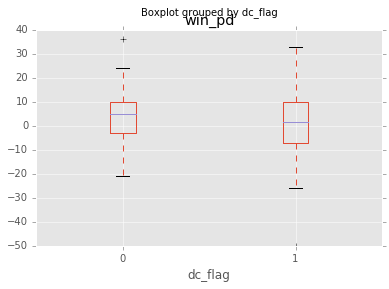

In [24]:
chh_four_factors.boxplot(column='win_pd', by='dc_flag')

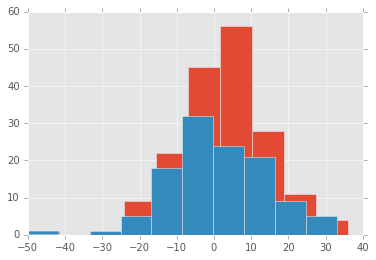

In [25]:
## Add legend
ax = chh_four_factors['win_pd'].hist()
chh_four_factors[chh_four_factors['dc_flag']==1]['win_pd'].hist(ax=ax)

## 1 Sample T-Test

In [26]:
stats.ttest_1samp(chh_four_factors['win_flag'], .5)

Ttest_1sampResult(statistic=2.0476672523802768, pvalue=0.042078522859505384)

## 2 Sample T-Test Unequal Variance 

In [27]:
stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['win_flag'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['win_flag'], equal_var=False)

Ttest_indResult(statistic=2.6137973430365662, pvalue=0.0099959320731717663)

## Offensive & Defensive Ratings

In [28]:
chh_four_factors.head()

,away,away_efg_pct,away_ft_rate,away_off_rtg,away_orb_pct,away_pace,away_tov_pct,home,home_efg_pct,home_ft_rate,home_off_rtg,home_orb_pct,home_pace,home_tov_pct,id,chh_flag,win_flag,win_pd,dc_flag
0,ORL,.425,.225,84.7,26.7,101.5,19.3,CHH,.476,.268,98.5,28.0,101.5,17.6,/boxscores/199911020CHH.html,1,1,14,1
1,IND,.514,.225,86.2,15.2,103.3,28.6,CHH,.460,.207,94.9,19.2,103.3,11.5,/boxscores/199911040CHH.html,1,1,9,1
2,CHH,.500,.333,104.1,28.2,96.1,17.4,BOS,.471,.241,107.2,37.5,96.1,14.6,/boxscores/199911050BOS.html,1,0,-3,1
3,CHH,.500,.456,105.6,31.4,93.7,21.2,TOR,.580,.080,116.3,28.9,93.7,13.2,/boxscores/199911070TOR.html,1,0,-10,1
4,MIL,.558,.325,124.1,37.1,89.4,13.5,CHH,.557,.367,130.8,28.6,89.4,9.5,/boxscores/199911100CHH.html,1,1,6,1


In [29]:
chh_four_factors['chh_off_rtg'] = chh_four_factors.apply(lambda row: row['away_off_rtg'] if row['away']=='CHH' else row['home_off_rtg'], axis=1).astype(float)
chh_four_factors['chh_def_rtg'] = chh_four_factors.apply(lambda row: row['home_off_rtg'] if row['away']=='CHH' else row['away_off_rtg'], axis=1).astype(float)

In [30]:
print chh_four_factors.groupby('dc_flag')['chh_off_rtg'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_off_rtg'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['chh_off_rtg'], equal_var=False)

dc_flag
0    104.475410
1    104.127586
Name: chh_off_rtg, dtype: float64
Ttest_indResult(statistic=0.19681633637260007, pvalue=0.84429592070088544)


In [31]:
print chh_four_factors.groupby('dc_flag')['chh_def_rtg'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_def_rtg'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['chh_def_rtg'], equal_var=False)

dc_flag
0     99.309836
1    102.652586
Name: chh_def_rtg, dtype: float64
Ttest_indResult(statistic=-1.7887458361130661, pvalue=0.075912662631771377)


## Four Factors

In [32]:
chh_four_factors['chh_def_efg'] = chh_four_factors.apply(lambda row: row['home_efg_pct'] if row['away']=='CHH' else row['away_efg_pct'], axis=1).astype(float)
chh_four_factors['chh_def_orb'] = chh_four_factors.apply(lambda row: row['home_orb_pct'] if row['away']=='CHH' else row['away_orb_pct'], axis=1).astype(float)
chh_four_factors['chh_def_tov'] = chh_four_factors.apply(lambda row: row['home_tov_pct'] if row['away']=='CHH' else row['away_tov_pct'], axis=1).astype(float)
chh_four_factors['chh_def_ftrate'] = chh_four_factors.apply(lambda row: row['home_ft_rate'] if row['away']=='CHH' else row['away_ft_rate'], axis=1).astype(float)

In [33]:
print chh_four_factors.groupby('dc_flag')['chh_def_efg'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_def_efg'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['chh_def_efg'], equal_var=False)

dc_flag
0    0.454361
1    0.475612
Name: chh_def_efg, dtype: float64
Ttest_indResult(statistic=-2.1835990346700354, pvalue=0.030696316525347083)


In [34]:
print chh_four_factors.groupby('dc_flag')['chh_def_orb'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_def_orb'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['chh_def_orb'], equal_var=False)

dc_flag
0    25.481967
1    26.382759
Name: chh_def_orb, dtype: float64
Ttest_indResult(statistic=-0.81007374940485455, pvalue=0.41938034882261443)


In [35]:
print chh_four_factors.groupby('dc_flag')['chh_def_tov'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_def_tov'], 
                      chh_four_factors[chh_four_factors['dc_flag']==1]['chh_def_tov'], equal_var=False)

dc_flag
0    13.796721
1    13.709483
Name: chh_def_tov, dtype: float64
Ttest_indResult(statistic=0.15398948213527919, pvalue=0.87784682309756934)


In [36]:
print chh_four_factors.groupby('dc_flag')['chh_def_ftrate'].mean()
print stats.ttest_ind(chh_four_factors[chh_four_factors['dc_flag']==0]['chh_def_ftrate'], 
                chh_four_factors[chh_four_factors['dc_flag']==1]['chh_def_ftrate'], equal_var=False)

dc_flag
0    0.223361
1    0.209241
Name: chh_def_ftrate, dtype: float64
Ttest_indResult(statistic=1.0572161821820181, pvalue=0.29291482641012956)
